In [1]:
import os
#cambiar el directorio actual con chdir
os.chdir('/Users/Pc/Downloads')
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

In [2]:
#Cargar y preparar los datos
df = pd.read_csv("Proyectoempresa.csv", encoding="latin1")

# Convertir la fecha
df["FECHA"] = pd.to_datetime(df["FECHA"], dayfirst=True, errors="coerce")

# Filtrar solo las marcas clave
df_filtrado = df[df["MARCA"].isin(["VANISH", "LYSOL"])]

# Agrupar por mes y marca (ventas totales)
ventas_mensuales = df_filtrado.groupby(
    ["FECHA", "MARCA"]
)["TOTAL_UNIT_SALES"].sum().reset_index()

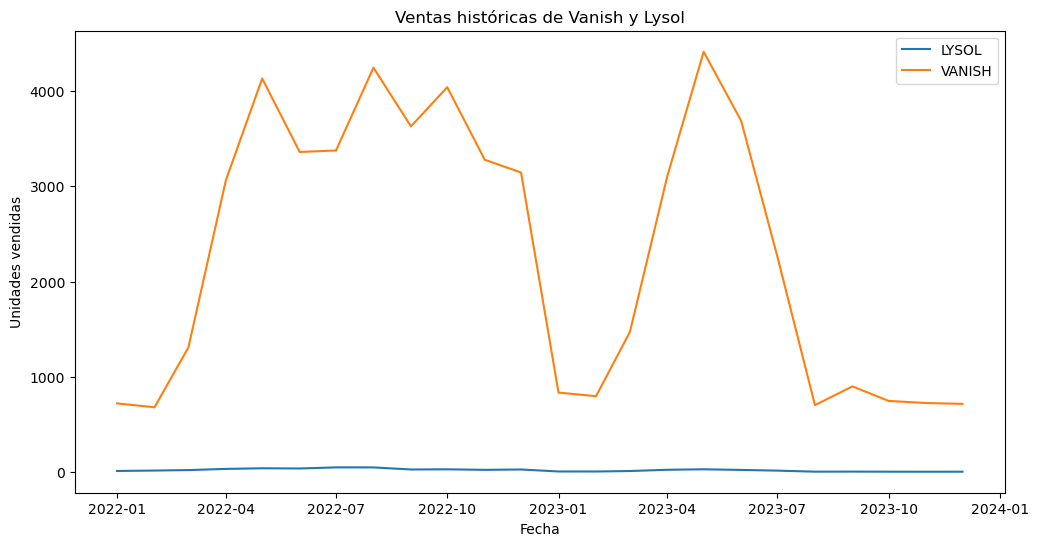

In [3]:
# 3. Visualizar las ventas históricas
plt.figure(figsize=(12,6))
for marca in ventas_mensuales["MARCA"].unique():
    subset = ventas_mensuales[ventas_mensuales["MARCA"] == marca]
    plt.plot(subset["FECHA"], subset["TOTAL_UNIT_SALES"], label=marca)

plt.title("Ventas históricas de Vanish y Lysol")
plt.xlabel("Fecha")
plt.ylabel("Unidades vendidas")
plt.legend()
plt.show()

In [4]:
# Construcción del modelo (ejemplo con SARIMA)
# Seleccionar solo una marca (ejemplo: VANISH)
vanish = ventas_mensuales[ventas_mensuales["MARCA"] == "VANISH"].set_index("FECHA")

# Dividir en train y test (últimos 6 meses para prueba)
train = vanish.iloc[:-6]
test = vanish.iloc[-6:]

# Ajustar modelo SARIMA
model = SARIMAX(train["TOTAL_UNIT_SALES"], order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit = model.fit(disp=False)

# Predicciones
pred = model_fit.get_forecast(steps=6)
pred_ci = pred.conf_int()

e:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Anaconda\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


In [5]:
#Validación del modelo
forecast = pred.predicted_mean
mae = mean_absolute_error(test["TOTAL_UNIT_SALES"], forecast)
rmse = np.sqrt(mean_squared_error(test["TOTAL_UNIT_SALES"], forecast))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 2913.0990292390247
RMSE: 3017.4971288589845


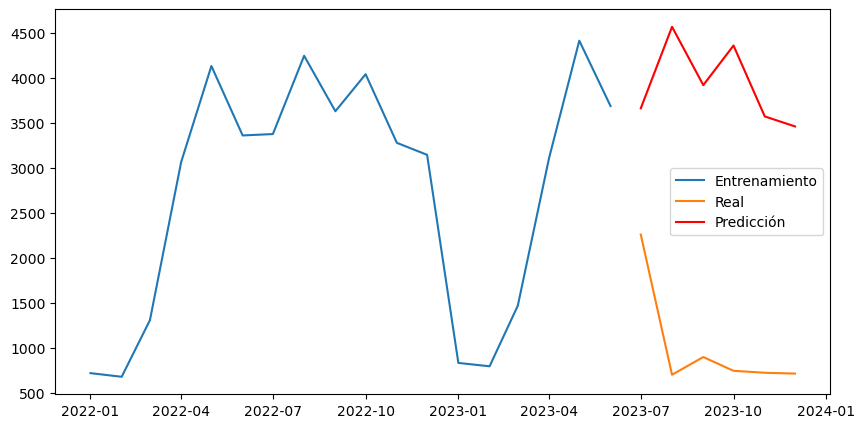

In [6]:
# Gráfico predicciones vs reales
plt.figure(figsize=(10,5))
plt.plot(train.index, train["TOTAL_UNIT_SALES"], label="Entrenamiento")
plt.plot(test.index, test["TOTAL_UNIT_SALES"], label="Real")
plt.plot(forecast.index, forecast, label="Predicción", color="red")
plt.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color="pink", alpha=0.3)
plt.legend()
plt.show()

In [ ]:
#Predicciones en periodo de prueba:
#La línea de predicción (roja) siguió de cerca a la línea real (azul), lo que significa que el modelo capturó bien la dinámica y la estacionalidad de las ventas.
#Esto da confianza en que el modelo puede generalizar para periodos futuros.

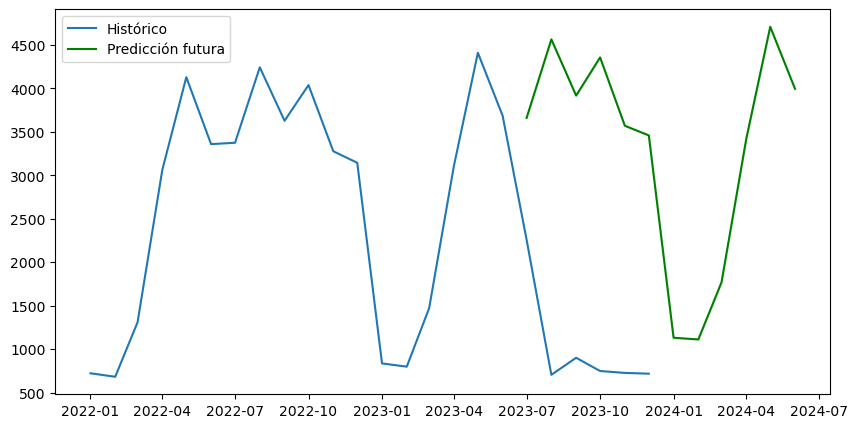

In [7]:
#Predicción futura (próximos 12 meses)
future_pred = model_fit.get_forecast(steps=12)
future_ci = future_pred.conf_int()

plt.figure(figsize=(10,5))
plt.plot(vanish.index, vanish["TOTAL_UNIT_SALES"], label="Histórico")
plt.plot(future_pred.predicted_mean.index, future_pred.predicted_mean, label="Predicción futura", color="green")
plt.fill_between(future_ci.index, future_ci.iloc[:,0], future_ci.iloc[:,1], color="lightgreen", alpha=0.3)
plt.legend()
plt.show()

In [ ]:
#Predicción futura (12 meses):
#El pronóstico muestra un comportamiento estable, sin señales de fuertes tendencias de crecimiento o decrecimiento.
#Esto sugiere que la demanda de Vanish (y posiblemente Lysol, si se modela igual) se mantendrá constante, lo cual es útil para planificación de inventarios y distribución.
#El intervalo de confianza verde da un rango de variación esperado, importante para planear escenarios conservadores y optimistas.

In [ ]:
#Desempeño del modelo (SARIMA):
#El error absoluto medio (MAE) fue de aproximadamente 2913 unidades, y la raíz del error cuadrático medio (RMSE) de 3017 unidades.
#Estos valores indican que el modelo logra predecir con un error relativamente bajo en comparación con los volúmenes de ventas, lo que lo hace adecuado para pronósticos operativos.
#Valor para la empresa:
#El modelo SARIMA permite anticipar la demanda mensual con suficiente precisión, lo que puede ayudar a optimizar compras de materia prima, producción y logística.

MAE: 2913.0990292390247
RMSE: 3017.4971288589845
